In [1]:
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
import seaborn as sns
import os,time, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Subset,DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
from google.colab import files
uploaded = files.upload()

Saving archive (10).zip to archive (10).zip


In [8]:
import zipfile
import os

zip_path = "archive (10).zip"   # your uploaded file
extract_path = "/content/emotion_data"

# Create destination folder
os.makedirs(extract_path, exist_ok=True)

# Extract ZIP
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extraction completed successfully!")


✅ Extraction completed successfully!


In [9]:
import os

# Updated path after extraction
data_path = '/content/emotion_data'

# List all folders and files inside extracted dataset
data = os.listdir(data_path)

print(f"📁 Total folders/files in this Dataset: {len(data)}")
print(f"📂 Files/Folders in this Dataset: {data}")


📁 Total folders/files in this Dataset: 2
📂 Files/Folders in this Dataset: ['train', 'test']


In [10]:
import os

data_path = '/content/emotion_data'
data = os.listdir(data_path)

for split in data:
    split_path = os.path.join(data_path, split)

    if os.path.isdir(split_path):
        classes = os.listdir(split_path)
        print(f"\n📂 Dataset Split: {split.upper()}")
        print(f"🧠 Total Classes: {len(classes)}")
        print(f"🎭 Classes: {classes}")

        counts = {}
        for cls in classes:
            cls_path = os.path.join(split_path, cls)
            counts[cls] = len(os.listdir(cls_path))

        print("📸 Samples per Class:")
        for cls, count in counts.items():
            print(f"   {cls:15s}: {count}")



📂 Dataset Split: TRAIN
🧠 Total Classes: 7
🎭 Classes: ['fearful', 'disgusted', 'angry', 'surprised', 'neutral', 'sad', 'happy']
📸 Samples per Class:
   fearful        : 4097
   disgusted      : 436
   angry          : 3995
   surprised      : 3171
   neutral        : 4965
   sad            : 4830
   happy          : 7215

📂 Dataset Split: TEST
🧠 Total Classes: 7
🎭 Classes: ['fearful', 'disgusted', 'angry', 'surprised', 'neutral', 'sad', 'happy']
📸 Samples per Class:
   fearful        : 1024
   disgusted      : 111
   angry          : 958
   surprised      : 831
   neutral        : 1233
   sad            : 1247
   happy          : 1774


Total training images: 28709
Classes: ['fearful', 'disgusted', 'angry', 'surprised', 'neutral', 'sad', 'happy']


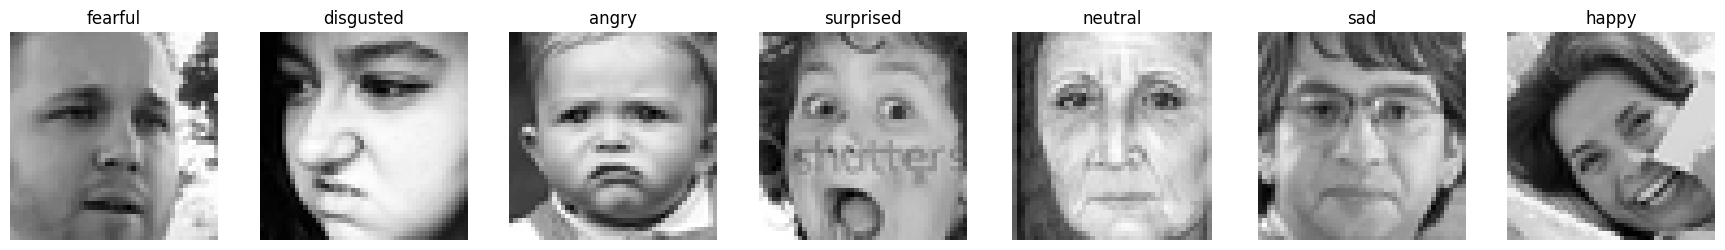

Sample image size (W x H): (48, 48)


In [11]:
import os
import random
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

train_dir = os.path.join(data_path, "train")

# Get all images in all class subfolders
image_paths = glob(os.path.join(train_dir, "*", "*"))
print(f"Total training images: {len(image_paths)}")

# Get list of classes
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
print(f"Classes: {classes}")

# Plot 1 random image from each class
fig, axes = plt.subplots(1, len(classes), figsize=(22, 8))

for ax, cls in zip(axes, classes):
    cls_images = glob(os.path.join(train_dir, cls, "*"))
    img_path = random.choice(cls_images)
    img = Image.open(img_path).convert("L")  # Convert to grayscale

    ax.imshow(img, cmap="gray")
    ax.set_title(cls)
    ax.axis("off")

plt.show()

# Print image size of the last image
print("Sample image size (W x H):", img.size)


In [13]:
import os
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

# ====== 1. Transforms ======
train_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1,1]
])

eval_tf = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# ====== 2. Load full train dataset ======
train_dataset_full = datasets.ImageFolder(os.path.join(data_path, "train"), transform=None)
print(f"Train set size before augmentation and split: {len(train_dataset_full)}")

class_names = train_dataset_full.classes
y = np.array(train_dataset_full.targets)
idxs = np.arange(len(y))

# ====== 3. Stratified split (10% validation) ======
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
train_idx, val_idx = next(splitter.split(idxs, y))

# ====== 4. Create Dataset subsets ======
# Full datasets with transforms
train_dataset_aug = datasets.ImageFolder(os.path.join(data_path, "train"), transform=train_tf)
train_dataset_eval = datasets.ImageFolder(os.path.join(data_path, "train"), transform=eval_tf)

# Subsets for train and validation
train_dataset = Subset(train_dataset_aug, train_idx)
val_dataset = Subset(train_dataset_eval, val_idx)

# ====== 5. Test Dataset ======
test_dataset = datasets.ImageFolder(os.path.join(data_path, "test"), transform=eval_tf)

# ====== 6. Print dataset sizes ======
print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")

# ====== 7. DataLoaders ======
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)


Train set size before augmentation and split: 28709
Train set size: 25838
Validation set size: 2871
Test set size: 7178


In [15]:
# 4. Model Architecture (CNN)
import torch
import torch.nn as nn

class CNNEmotion(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNEmotion, self).__init__()

        # ===== Convolutional layers =====
        self.conv_layers = nn.Sequential(
            # 1st Conv Block
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),  # 48x48 -> 24x24

            # 2nd Conv Block
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),  # 24x24 -> 12x12

            # 3rd Conv Block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2),  # 12x12 -> 6x6

            # 4th Conv Block
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.MaxPool2d(2, 2)   # 6x6 -> 3x3
        )

        # ===== Fully Connected layers =====
        self.fc_layers = nn.Sequential(
            nn.Linear(256*3*3, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Feature extraction
        x = self.conv_layers(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Classification
        x = self.fc_layers(x)
        return x


In [16]:
import torch
from torchsummary import summary  # optional, for model summary

# ===== Set device =====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ===== Initialize model =====
model = CNNEmotion(num_classes=len(class_names)).to(device)

# ===== Optional: print model summary =====
# Make sure input size matches your data (1 channel, 48x48)
try:
    summary(model, input_size=(1, 48, 48))
except:
    print("Install torchsummary if you want a model summary: pip install torchsummary")


Using device: cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
       BatchNorm2d-2           [-1, 32, 48, 48]              64
              ReLU-3           [-1, 32, 48, 48]               0
           Dropout-4           [-1, 32, 48, 48]               0
         MaxPool2d-5           [-1, 32, 24, 24]               0
            Conv2d-6           [-1, 64, 24, 24]          18,496
       BatchNorm2d-7           [-1, 64, 24, 24]             128
              ReLU-8           [-1, 64, 24, 24]               0
           Dropout-9           [-1, 64, 24, 24]               0
        MaxPool2d-10           [-1, 64, 12, 12]               0
           Conv2d-11          [-1, 128, 12, 12]          73,856
      BatchNorm2d-12          [-1, 128, 12, 12]             256
             ReLU-13          [-1, 128, 12, 12]               0
          Dropout-14

In [17]:
import torch
import torch.nn.functional as F

# ===== Accuracy computation =====
def accuracy_from_logits(logits, y):
    """
    Computes accuracy from raw model logits and true labels.
    """
    preds = torch.argmax(logits, dim=1)      # predicted class
    correct = (preds == y).float()           # 1 for correct, 0 for wrong
    return correct.mean().item()

# ===== Run one epoch =====
def run_epoch(model, loader, optimizer=None, device='cuda'):
    """
    Runs one epoch of training or evaluation.
    If optimizer is provided, runs training; otherwise evaluation.
    Returns average loss and accuracy.
    """
    is_train = optimizer is not None
    model.train(is_train)  # train or eval mode

    total_loss, total_acc, total_samples = 0.0, 0.0, 0

    # Disable gradient tracking for evaluation
    if not is_train:
        torch.set_grad_enabled(False)

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        # Forward pass
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # gradient clipping
            optimizer.step()

        # Track statistics
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_acc  += accuracy_from_logits(logits, y) * batch_size
        total_samples += batch_size

    # Re-enable gradients if they were disabled
    if not is_train:
        torch.set_grad_enabled(True)

    avg_loss = total_loss / total_samples
    avg_acc = total_acc / total_samples

    return avg_loss, avg_acc


In [19]:
EPOCHS = 20
LR = 1e-3
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [20]:
best_val_loss = float('inf')   # best score so far
patience = 5                   # early stopping patience
wait = 0
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

t0_all = time.time()
for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    # Training epoch
    train_loss, train_acc = run_epoch(model, train_loader, optimizer=optimizer)

    # Validation epoch
    val_loss,   val_acc   = run_epoch(model, val_loader,   optimizer=None)

    # Save metrics
    history["train_loss"].append(train_loss); history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss);     history["val_acc"].append(val_acc)

    # Scheduler update (on validation loss)
    scheduler.step(val_loss)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.3f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.3f} | "
          f"{time.time() - t0:.1f}s")

    # Early stopping + checkpoint
    if val_loss + 1e-6 < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_cnn.pt")   # save best model
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

print(f"Total training time: {time.time() - t0_all:.1f}s")

Epoch 01 | train loss 1.5574 acc 0.389 | val loss 1.5259 acc 0.399 | 18.0s
Epoch 02 | train loss 1.3343 acc 0.490 | val loss 1.5206 acc 0.385 | 17.0s
Epoch 03 | train loss 1.2651 acc 0.519 | val loss 1.3236 acc 0.485 | 15.2s
Epoch 04 | train loss 1.2212 acc 0.540 | val loss 1.3338 acc 0.487 | 15.1s
Epoch 05 | train loss 1.1951 acc 0.548 | val loss 1.2249 acc 0.550 | 15.3s
Epoch 06 | train loss 1.1684 acc 0.559 | val loss 1.2237 acc 0.536 | 16.3s
Epoch 07 | train loss 1.1441 acc 0.567 | val loss 1.1875 acc 0.556 | 15.8s
Epoch 08 | train loss 1.1241 acc 0.574 | val loss 1.1831 acc 0.543 | 15.9s
Epoch 09 | train loss 1.1135 acc 0.580 | val loss 1.1867 acc 0.547 | 15.4s
Epoch 10 | train loss 1.0873 acc 0.590 | val loss 1.1301 acc 0.574 | 16.4s
Epoch 11 | train loss 1.0725 acc 0.595 | val loss 1.1224 acc 0.570 | 15.3s
Epoch 12 | train loss 1.0612 acc 0.599 | val loss 1.1595 acc 0.552 | 15.2s
Epoch 13 | train loss 1.0538 acc 0.602 | val loss 1.1211 acc 0.571 | 15.1s
Epoch 14 | train loss 1.0

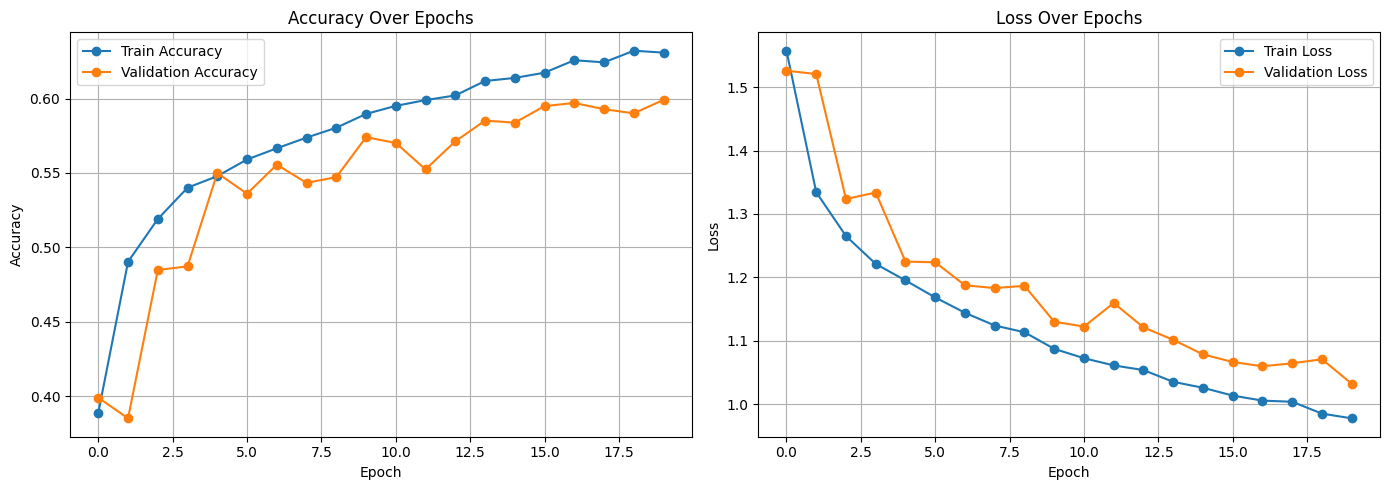

In [32]:
# metrics visualization code
import matplotlib.pyplot as plt

# ===== 6. Metrics Visualization =====
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ---- Accuracy Curves ----
axes[0].plot(history["train_acc"], marker='o', label="Train Accuracy")
axes[0].plot(history["val_acc"], marker='o', label="Validation Accuracy")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy")
axes[0].set_title("Accuracy Over Epochs")
axes[0].grid(True)
axes[0].legend()

# ---- Loss Curves ----
axes[1].plot(history["train_loss"], marker='o', label="Train Loss")
axes[1].plot(history["val_loss"], marker='o', label="Validation Loss")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss Over Epochs")
axes[1].grid(True)
axes[1].legend()

plt.tight_layout()
plt.show()


In [33]:
# 7. Evaluation & Error Analysis
import numpy as np
import torch

# ===== 7. Load Best Model =====
best_model = CNNEmotion(num_classes=len(class_names)).to(device)
best_model.load_state_dict(torch.load("best_cnn.pt", map_location=device))
best_model.eval()  # set to evaluation mode

# ===== 8. Evaluation on Test Set =====
all_preds = []
all_true = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = best_model(x)
        preds = logits.argmax(dim=1)  # predicted class
        all_preds.extend(preds.cpu().numpy())
        all_true.extend(y.cpu().numpy())

# Convert to NumPy arrays for metrics computation
all_preds = np.array(all_preds)
all_true = np.array(all_true)

# ===== 9. Test Accuracy =====
test_acc = (all_preds == all_true).mean()
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")


✅ Test Accuracy: 60.92%


In [24]:
from sklearn.metrics import classification_report

# ===== Test Accuracy =====
test_acc = (all_preds == all_true).mean()
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

# ===== Classification Report =====
print("\n📊 Classification Report:\n")
print(classification_report(
    all_true,
    all_preds,
    target_names=class_names,
    digits=4  # show 4 decimal places
))


✅ Test Accuracy: 60.92%

📊 Classification Report:

              precision    recall  f1-score   support

       angry     0.6379    0.3862    0.4811       958
   disgusted     0.8077    0.1892    0.3066       111
     fearful     0.5044    0.2783    0.3587      1024
       happy     0.8115    0.8348    0.8230      1774
     neutral     0.5308    0.6350    0.5783      1233
         sad     0.4285    0.6512    0.5169      1247
   surprised     0.7648    0.7473    0.7559       831

    accuracy                         0.6092      7178
   macro avg     0.6408    0.5317    0.5458      7178
weighted avg     0.6243    0.6092    0.6002      7178



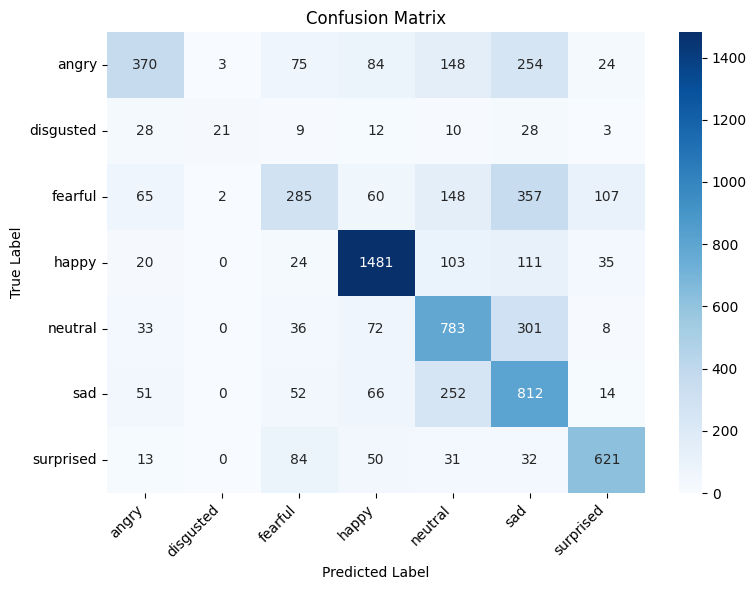

In [25]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# ===== Confusion Matrix =====
cm = confusion_matrix(all_true, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True,          # show counts
    fmt='d',             # integer format
    cmap='Blues',        # color map
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [26]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import random

def show_random_test_predictions(model, dataset, n=8, device='cuda'):
    """
    Display random test images with predicted and true labels.
    Correct predictions are shown in green, incorrect in red.
    """
    # Random indices
    idxs = random.sample(range(len(dataset)), n)
    imgs, labels = zip(*[dataset[i] for i in idxs])  # list of (C,H,W) tensors + int labels

    # Create batch
    batch = torch.stack(imgs).to(device)              # [n,1,48,48]
    labels_t = torch.tensor(labels).to(device)

    # Forward pass
    with torch.no_grad():
        logits = model(batch)
        probs = F.softmax(logits, dim=1)
        preds = probs.argmax(dim=1)

    # Determine grid size
    rows = 2
    cols = (n + 1) // rows

    # Plot images
    plt.figure(figsize=(3*cols, 3*rows))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        img = imgs[i].squeeze(0).cpu().numpy()  # (48,48)
        plt.imshow(img, cmap="gray")
        true_label = class_names[labels[i]]
        pred_label = class_names[preds[i].item()]
        color = "green" if true_label == pred_label else "red"
        plt.title(f"P: {pred_label}\nT: {true_label}", color=color, fontsize=10)
        plt.axis("off")
    plt.suptitle("Random Test Images: Predictions vs Ground Truth", fontsize=14)
    plt.tight_layout()
    plt.show()


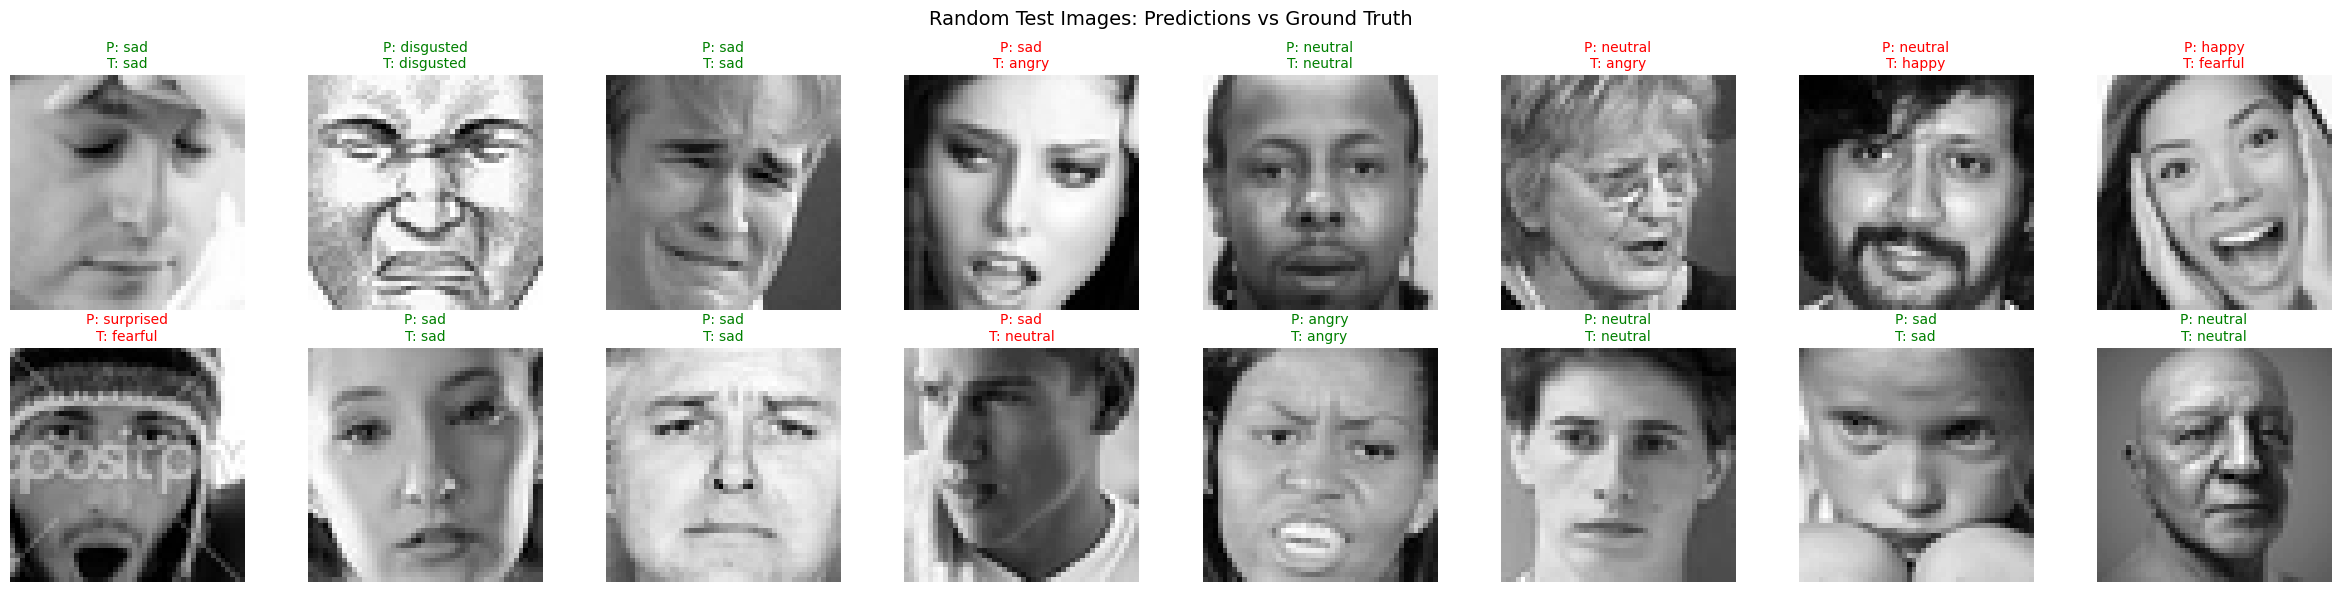

In [27]:
show_random_test_predictions(best_model, test_dataset, n=16)


In [28]:
from google.colab import files

# Download the saved model
files.download("best_cnn.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Image path
image_path = "handsome-man-smiling-happy-face-portrait-close-up_53876-146189.jpg"

# Load and preprocess
img = Image.open(image_path).convert("L")  # grayscale
img = img.resize((48,48))

transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0).to(device)  # [1,1,48,48]


In [30]:
with torch.no_grad():
    logits = model(img_tensor)
    probs = torch.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()
    confidence = float(probs[0][pred])

print(f"Predicted Emotion: {class_names[pred]}")
print(f"Confidence: {confidence*100:.2f}%")


Predicted Emotion: happy
Confidence: 76.51%


In [31]:
# Image path
image_path = "human-emotions-scream-hate-get-angry-crying-emotional-angry-man-screaming-studio-emotional-evil-face-man-facial-expression-concept_497171-922.jpg"

# Load and preprocess
img = Image.open(image_path).convert("L")  # grayscale
img = img.resize((48,48))

transform = transforms.ToTensor()
img_tensor = transform(img).unsqueeze(0).to(device)  # [1,1,48,48]
with torch.no_grad():
    logits = model(img_tensor)
    probs = torch.softmax(logits, dim=1)
    pred = probs.argmax(dim=1).item()
    confidence = float(probs[0][pred])

print(f"Predicted Emotion: {class_names[pred]}")
print(f"Confidence: {confidence*100:.2f}%")


Predicted Emotion: sad
Confidence: 30.99%
